In [193]:
import numpy as np
from sklearn.ensemble import StackingClassifier, BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix

In [236]:
lstm_scores = np.loadtxt(r'/home/mihai/Thesis/Data/TSC_scores/predicted_scores_overlap_50_lstm.csv',delimiter=',')[:,1]
rnn_scores = np.loadtxt(r'/home/mihai/Thesis/Data/TSC_scores/predicted_scores_overlap_50_rnn.csv',delimiter=',')[:,1]
inception_scores = np.loadtxt(r'/home/mihai/Thesis/Data/TSC_scores/predicted_labels_overlap_50_inceptionnet.csv',delimiter=',')
fcn_scores = np.loadtxt(r'/home/mihai/Thesis/Data/TSC_scores/predicted_scores_overlap_50_fcn.csv',delimiter=',')[:,1]
resnet_scores = np.loadtxt(r'/home/mihai/Thesis/Data/TSC_scores/predicted_scores_overlap_50_resnet.csv',delimiter=',')[:,1]

true_labels = np.loadtxt('/home/mihai/Thesis/Data/TSC_scores/true_labels_50_overlap.csv', delimiter=',')

tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')


# Combine scores into a single array
scores = np.stack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores], axis=1)
X_train, X_test, y_train, y_test = train_test_split(scores, true_labels, test_size=0.2, random_state=42)


## Utility functions (they appear 10 times in other places :( )

In [195]:
def match_changepoints(true_changepoints, predicted_changepoints, tolerance=5):
    """
    Matches each predicted changepoint to a true changepoint within a tolerance window
    and returns counts of matches for precision and recall calculation.
    """
    # Ensure true_changepoints and predicted_changepoints are lists of individual points
    true_changepoints = list(true_changepoints)
    predicted_changepoints = list(predicted_changepoints)

    true_matched = set()  # Keeps track of matched true changepoints
    pred_matched = set()  # Keeps track of matched predicted changepoints

    # Try to match each predicted changepoint to a true changepoint
    for pred_cp in predicted_changepoints:
        for true_cp in true_changepoints:
            # Check if the difference between pred_cp and true_cp is within tolerance
            if abs(pred_cp - true_cp) <= tolerance and true_cp not in true_matched:
                true_matched.add(true_cp)
                pred_matched.add(pred_cp)
                break  # Move to next predicted changepoint after finding a match

    # True positives, predicted positives, and total true changepoints
    true_positives = len(true_matched)
    pred_positives = len(pred_matched)
    total_true = len(true_changepoints)
    total_pred = len(predicted_changepoints)

    return true_positives, pred_positives, total_true, total_pred

def smooth_predictions(predicted_labels):
    predicted_labels_smoother = np.copy(predicted_labels)
    for i in range(1, len(predicted_labels)-1):
        if predicted_labels[i] == 1 and (predicted_labels[i-1] == 0 and predicted_labels[i+1] == 0):
            predicted_labels_smoother[i] = 0

    return predicted_labels_smoother

def compute_precision_recall_f1(true_changepoints, predicted_changepoints, tolerance=5):
    """
    Computes precision, recall, and F1-score for changepoint detection based on
    matched changepoints within a given tolerance window.
    """
    true_positives, _, total_true, total_pred = match_changepoints(
        true_changepoints, predicted_changepoints, tolerance
    )

    # Precision: fraction of predicted changepoints that are correct
    precision = true_positives / total_pred if total_pred > 0 else 0

    # Recall: fraction of true changepoints that are correctly predicted
    recall = true_positives / total_true if total_true > 0 else 0

    # F1 Score: harmonic mean of precision and recall
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def compute_total_precision_recall_f1(real_changepoints, predicted_changepoints, tolerance=5):
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    for real_cp, pred_cp in zip(real_changepoints, predicted_changepoints):
        precision, recall, f1_score = compute_precision_recall_f1(real_cp, pred_cp, tolerance)
        total_precision += precision
        total_recall += recall
        total_f1_score += f1_score

    return total_precision / len(real_changepoints), total_recall / len(real_changepoints), total_f1_score / len(real_changepoints)


def compute_changepoints(tc_signal):
    cps_array = []
    for col_idx in range(tc_signal.shape[1]):
        # Compute the difference along the column with NaN prepended
        diffs = np.diff(tc_signal[:, col_idx], prepend=np.nan)
        # Find the change points (from 0 to 1)
        cps = np.where((diffs == 1))[0]
        cps_array.append(cps)

    return cps_array


def plot_heatmap(true_labels, predicted_labels):
  plt.figure(figsize=(10, 7))

  cm = confusion_matrix(true_labels, predicted_labels)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=np.arange(cm.shape[1]),
              yticklabels=np.arange(cm.shape[0]))
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

def generate_heatmap(precision_grid, recall_grid, f1_grid, tolerances, thresholds):
    # Plot the heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(precision_grid, xticklabels=np.round(thresholds,3), yticklabels=np.round(tolerances,3), ax=axs[0], cmap='Blues', annot=True, fmt=".2f")
    axs[0].set_title("Precision Heatmap")
    axs[0].set_xlabel("Threshold")
    axs[0].set_ylabel("Tolerance")

    sns.heatmap(recall_grid, xticklabels=np.round(thresholds,3), yticklabels=np.round(tolerances,3), ax=axs[1], cmap='Greens', annot=True, fmt=".2f")
    axs[1].set_title("Recall Heatmap")
    axs[1].set_xlabel("Threshold")
    axs[1].set_ylabel("Tolerance")

    sns.heatmap(f1_grid, xticklabels=np.round(thresholds,3), yticklabels=np.round(tolerances,3), ax=axs[2], cmap='Reds', annot=True, fmt=".2f")
    axs[2].set_title("F1 Score Heatmap")
    axs[2].set_xlabel("Threshold")
    axs[2].set_ylabel("Tolerance")

    plt.tight_layout()
    plt.show()

def compute_avg_delay_aux(true_changepoints, predicted_changepoints, tolerance=5):
    """
    Matches predicted changepoints to true changepoints within a tolerance window and computes metrics.
    """
    # Ensure inputs are lists
    true_changepoints = list(true_changepoints)
    predicted_changepoints = list(predicted_changepoints)

    true_matched = set()  # Tracks matched true changepoints
    pred_matched = set()  # Tracks matched predicted changepoints
    detection_delays = []  # Stores time differences between matched pairs

    for pred_cp in predicted_changepoints:
        for true_cp in true_changepoints:
            if abs(pred_cp - true_cp) <= tolerance and true_cp not in true_matched:
                true_matched.add(true_cp)
                pred_matched.add(pred_cp)
                detection_delays.append(abs(pred_cp - true_cp))  # Record delay
                break

    avg_detection_delay = sum(detection_delays) / len(detection_delays) if detection_delays else None

    return avg_detection_delay

def compute_avg_delay(true_changepoints, predicted_changepoints, tolerance=5):
    avg_detection_delays = []
    for idx, true_cp in enumerate(true_changepoints):
        avg_detection_delay = compute_avg_delay_aux(true_cp, predicted_changepoints[idx], tolerance=tolerance)
        avg_detection_delays.append(avg_detection_delay)

    return np.array(avg_detection_delays)


def compute_black_box_detection_times(black_box_predicted_scores, threshold, window_size=150, overlap=0.5, waiting_parameter=150):
    """
    Computes detection times for a black-box model based on predictions, extended labels, and a waiting threshold.

    Parameters:
    - black_box_predicted_scores: Array of predicted scores from the black-box model.
    - threshold: Threshold for binarizing predicted scores into labels.
    - window_size: Size of the window used for extending predictions.
    - overlap: Fraction of overlap between consecutive windows.
    - waiting_parameter: Parameter for computing distraction times in `compute_distraction_times`.

    Returns:
    - detection_times: A list of distraction detection times for each run.
    """
    # Binarize scores to get predicted labels
    black_box_predicted_labels = black_box_predicted_scores > threshold

    # Extend the predicted labels with overlap
    extended_labels = extend_predictions(
        black_box_predicted_labels, window_size=window_size, overlap=0.5
    ).reshape(40, -1)  # Assuming 40 runs/windows

    # Compute distraction times for each run
    detection_times = []
    for idx in range(extended_labels.shape[0]):
        detection_times.append(
            compute_distraction_times(extended_labels[idx], threshold=waiting_parameter)
        )

    return detection_times

def extend_predictions(prediction_scores, window_size=150, overlap=0.5):
    """
    Extends the predictions to the original time series length by repeating the predictions
    for each window, considering an overlap between consecutive windows.

    Parameters:
    - prediction_scores: The prediction scores from the model (assumed to be a numpy array).
    - window_size: The size of the window used for prediction.
    - overlap: The fraction of the window that overlaps between consecutive windows (0 <= overlap < 1).

    Returns:
    - extended_prediction_scores: The prediction scores extended to the original time series length.
    """

    # Validate overlap
    if not (0 <= overlap < 1):
        raise ValueError("Overlap must be between 0 and 1 (exclusive).")

    step_size = int(window_size * (1 - overlap))  # Effective step size between windows
    total_length = step_size * (len(prediction_scores))

    # Initialize arrays for extended predictions
    extended_prediction_scores = np.zeros(total_length)

    # Fill the extended arrays
    for i, score in enumerate(prediction_scores):
        start_idx = i * step_size

        if i == len(prediction_scores) - 1:
            end_idx = start_idx + step_size

        else:
            end_idx = start_idx + step_size

        extended_prediction_scores[start_idx:end_idx] = score

    return extended_prediction_scores


def compute_distraction_times(extended_black_box_scores, threshold=150):
    """
    Compute the performance metrics for the black box model with extended predictions.

    A distraction is considered detected after `threshold` consecutive 1s. After a distraction
    is detected, no other detections are considered until a 0 is encountered, which resets the counter.

    Parameters:
    - extended_black_box_scores: A list or numpy array of binary scores (0s and 1s).
    - threshold: The number of consecutive 1s required to detect a distraction.

    Returns:
    - detection_times: A list of indices where distractions were detected.
    """

    detection_times = []  # List to store the indices where distractions are detected
    consecutive_ones = 0  # Counter for consecutive 1s
    in_detection = False  # Flag to indicate if we are in a distraction detection period

    for i, score in enumerate(extended_black_box_scores):
        if score == 1:
            # Increment the counter for consecutive 1s
            consecutive_ones += 1

            # If threshold is reached and we are not already in a detection period
            if consecutive_ones >= threshold and not in_detection:
                detection_times.append(i)  # Record the time of detection
                in_detection = True  # Set the flag to indicate a distraction is detected
        else:
            # Reset the counter and flag when a 0 is encountered
            consecutive_ones = 0
            in_detection = False

    return detection_times

def filter_isolated_predictions(predictions):
    """
    Filters the predictions array such that any isolated 1 (without adjacent 0s) is set to 0.

    Parameters:
    predictions (numpy.ndarray): Array of predicted labels (1D array).

    Returns:
    numpy.ndarray: Filtered predictions array.
    """
    filtered_predictions = predictions.copy()

    for i in range(1, len(predictions) - 1):
        if predictions[i] == 1 and predictions[i - 1] == 0 and predictions[i + 1] == 0:
            filtered_predictions[i] = 0

    return filtered_predictions


def evaluate_thresholds(preds, true_labels, thresholds):
    """
    Iterates through thresholds to compute F1 score and accuracy for each threshold.

    Parameters:
    preds (numpy.ndarray): Array of prediction scores (continuous values).
    true_labels (numpy.ndarray): Array of true labels.
    thresholds (list or numpy.ndarray): List of thresholds to evaluate.

    Returns:
    dict: Dictionary with thresholds as keys and (F1 score, accuracy) as values.
    """
    results = {}
    for threshold in thresholds:
        print("threshold")
        binary_predictions = (preds >= threshold).astype(int)
        filtered_binary_predictions = filter_isolated_predictions(binary_predictions)
        f1 = f1_score(true_labels, filtered_binary_predictions)
        accuracy = accuracy_score(true_labels, filtered_binary_predictions)
        results[threshold] = (f1, accuracy)
        print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return results



In [196]:
real_changepoints = compute_changepoints(tc_test.reshape(-1, 40))

## Hard voting

In [197]:
lstm_preds = (lstm_scores >= 0.85).astype(int)
rnn_preds = (rnn_scores >= 0.85).astype(int)
fcn_preds = (fcn_scores >= 0.85).astype(int)
resnet_preds = (resnet_scores >= 0.85).astype(int)
inception_preds = (inception_scores >= 0.85).astype(int)

# Stack all predictions into a matrix (rows: samples, columns: models)
all_preds = np.vstack([lstm_preds, rnn_preds, fcn_preds, resnet_preds, inception_preds]).T

# Apply hard voting (majority vote)
hard_vote_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=all_preds)

# Evaluate the hard vote classifier
accuracy = accuracy_score(true_labels, hard_vote_preds)
conf_matrix = confusion_matrix(true_labels, hard_vote_preds)

# Print results
print(f"Hard Vote Accuracy: {accuracy:.4f}")
print(f"Hard vote f1 score: {f1_score(true_labels, hard_vote_preds)}")
print("Confusion Matrix:")
print(conf_matrix)

Hard Vote Accuracy: 0.7913
Hard vote f1 score: 0.3845076994867009
Confusion Matrix:
[[4589  945]
 [ 374  412]]


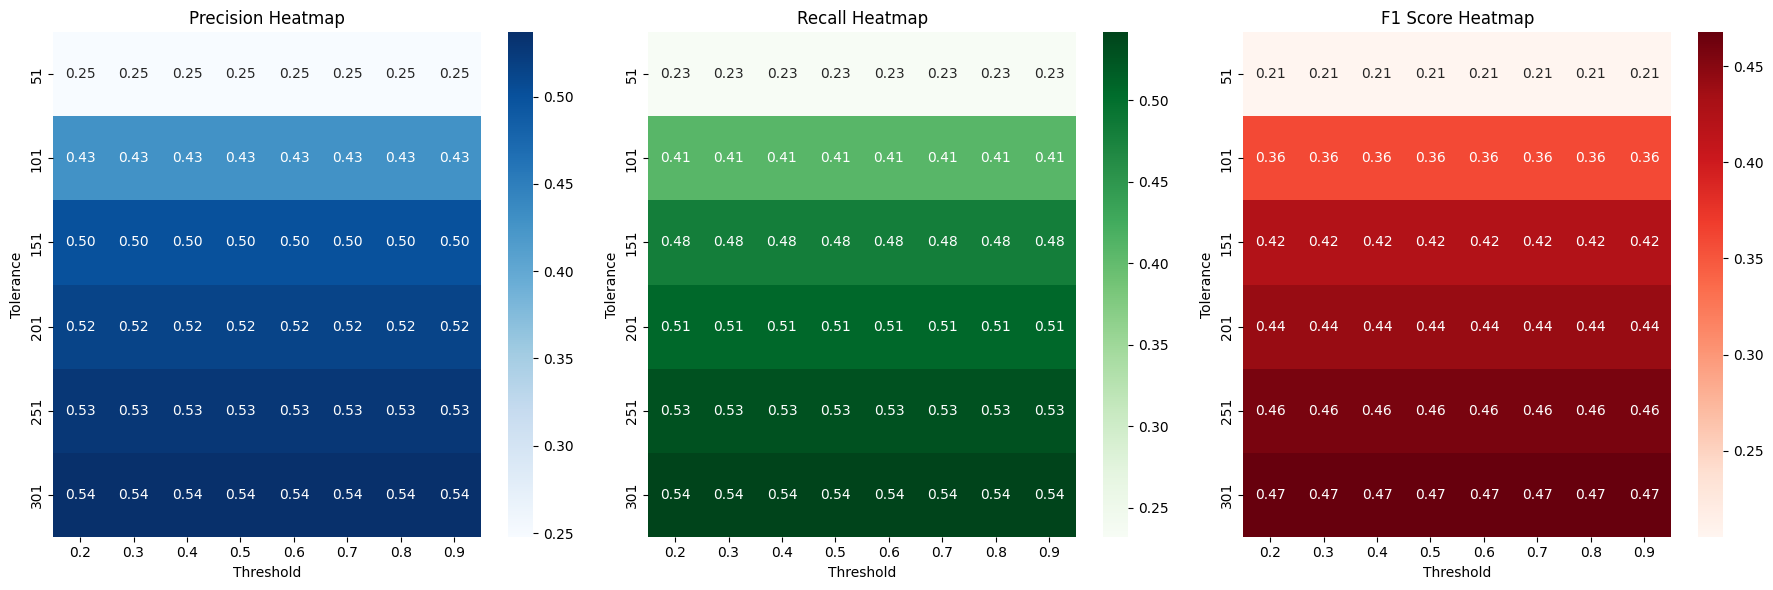

In [198]:
tolerances = np.arange(51, 351, 50)  # Tolerance values to test
thresholds = np.arange(0.2, 1, 0.1)  # Threshold values to test

# Initialize result matrices
precision_matrix = np.zeros((len(tolerances), len(thresholds)))
recall_matrix = np.zeros((len(tolerances), len(thresholds)))
f1_matrix = np.zeros((len(tolerances), len(thresholds)))
avg_delay_grid = np.zeros((len(tolerances), len(thresholds)))

for t_idx, tolerance in enumerate(tolerances):
    for th_idx, threshold in enumerate(thresholds):
        total_delay = 0
        detection_times = compute_black_box_detection_times(hard_vote_preds, threshold, window_size=150, overlap=0.5, waiting_parameter=150)
        avg_delay = compute_avg_delay(real_changepoints, detection_times, tolerance=tolerance)
        total_precision, total_recall, total_f1_score = compute_total_precision_recall_f1(real_changepoints, detection_times, tolerance=tolerance)

        total_delay = sum(x for x in avg_delay if x is not None)

        avg_delay_grid[t_idx, th_idx] = total_delay / len([x for x in avg_delay if x is not None])

        # Accumulate results across runs (mean metrics over runs)
        precision_matrix[t_idx, th_idx] += total_precision
        recall_matrix[t_idx, th_idx] += total_recall
        f1_matrix[t_idx, th_idx] += total_f1_score


generate_heatmap(precision_matrix, recall_matrix, f1_matrix, tolerances, thresholds)


## Averaging

Weighted Average Accuracy: 0.82
Filtered F1 Score: 0.3944116066630844
Filtered Accuracy: 0.8216772151898735


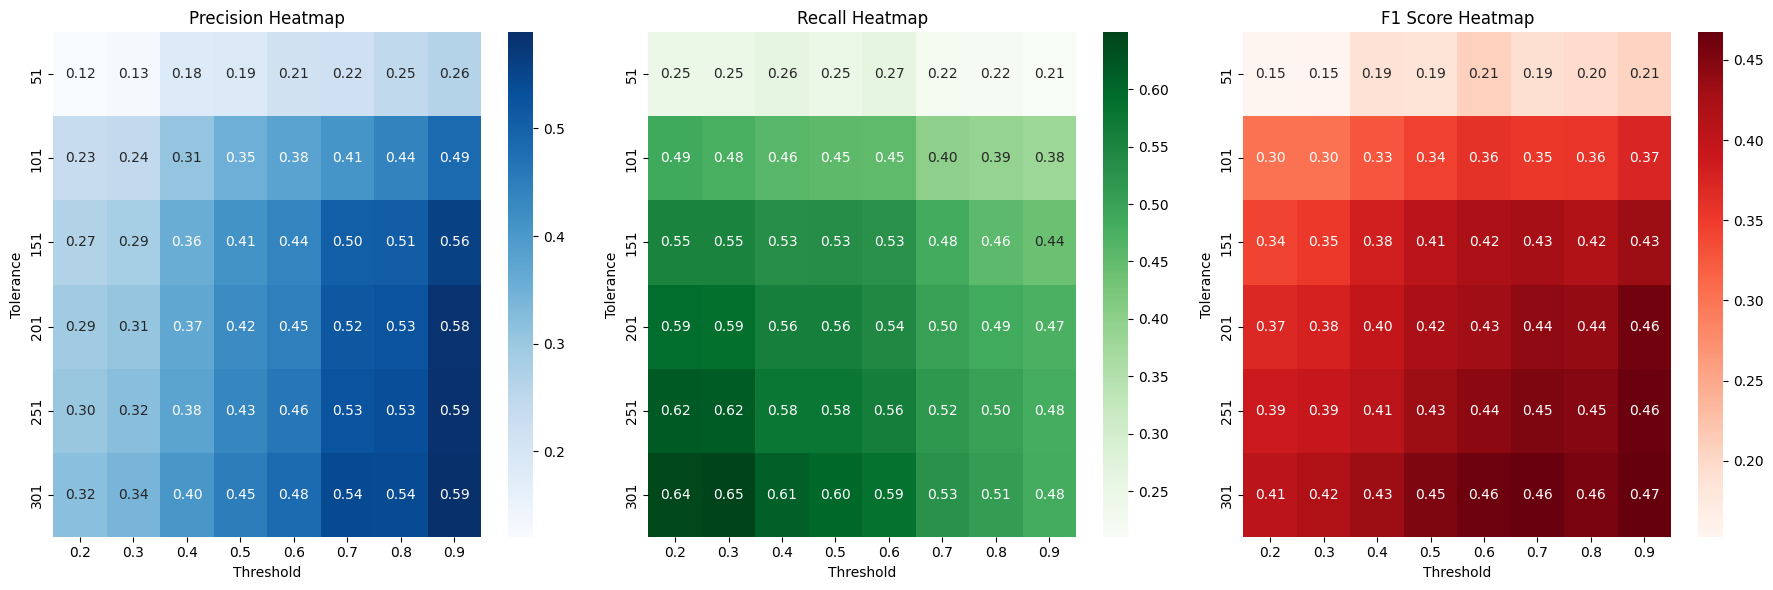

In [230]:
# Define weights for each model
#weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights, adjust as needed
weights = [0.333, 0 , 0, 0.667, 0 ]

# Weighted Average Prediction
weighted_avg_scores = np.average(scores, axis=1, weights=weights)

weighted_predicted_labels = weighted_avg_scores > 0.85 


# Accuracy of Weighted Average
weighted_avg_accuracy = accuracy_score(true_labels, weighted_predicted_labels)

print(f"Weighted Average Accuracy: {weighted_avg_accuracy:.2f}")


# Filter predictions
filtered_predictions = filter_isolated_predictions(weighted_predicted_labels)

# Compute F1 score and Accuracy with filtered predictions
f1 = f1_score(true_labels, weighted_predicted_labels)
accuracy = accuracy_score(true_labels, weighted_predicted_labels)

print(f'Filtered F1 Score: {f1}')
print(f'Filtered Accuracy: {accuracy}')


# Initialize result matrices
precision_matrix = np.zeros((len(tolerances), len(thresholds)))
recall_matrix = np.zeros((len(tolerances), len(thresholds)))
f1_matrix = np.zeros((len(tolerances), len(thresholds)))
avg_delay_grid = np.zeros((len(tolerances), len(thresholds)))

for t_idx, tolerance in enumerate(tolerances):
    for th_idx, threshold in enumerate(thresholds):
        total_delay = 0
        detection_times = compute_black_box_detection_times(weighted_avg_scores, threshold, window_size=150, overlap=0.5, waiting_parameter=150)
        avg_delay = compute_avg_delay(real_changepoints, detection_times, tolerance=tolerance)
        total_precision, total_recall, total_f1_score = compute_total_precision_recall_f1(real_changepoints, detection_times, tolerance=tolerance)

        total_delay = sum(x for x in avg_delay if x is not None)

        avg_delay_grid[t_idx, th_idx] = total_delay / len([x for x in avg_delay if x is not None])

        # Accumulate results across runs (mean metrics over runs)
        precision_matrix[t_idx, th_idx] += total_precision
        recall_matrix[t_idx, th_idx] += total_recall
        f1_matrix[t_idx, th_idx] += total_f1_score


generate_heatmap(precision_matrix, recall_matrix, f1_matrix, tolerances, thresholds)

In [121]:
def find_best_threshold(weighted_avg_scores, true_labels, threshold_range=np.arange(0.5, 1.0, 0.01)):
    """
    Find the best threshold for classification based on weighted average scores.
    The function will return the threshold that maximizes the F1 score or accuracy.

    :param weighted_avg_scores: The weighted average scores (from model predictions).
    :param true_labels: The true labels.
    :param threshold_range: Range of thresholds to search over.
    
    :return: The best threshold, corresponding F1 score, and accuracy.
    """
    best_threshold = None
    best_f1 = -1
    best_accuracy = -1
    
    for threshold in threshold_range:
        # Classify based on the current threshold
        predicted_labels = weighted_avg_scores > threshold
        
        # Compute F1 score and accuracy
        f1 = f1_score(true_labels, predicted_labels)
        accuracy = accuracy_score(true_labels, predicted_labels)
        
        # Update the best threshold based on highest F1 score or accuracy
        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy
            best_threshold = threshold
    
    # Return the best threshold, F1 score, and accuracy
    return best_threshold, best_f1, best_accuracy


best_threshold, best_f1, best_accuracy = find_best_threshold(weighted_avg_scores, true_labels)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")

Best Threshold: 0.90
Best F1 Score: 0.40
Best Accuracy: 0.84


## Weighted average

In [256]:
from itertools import product

def find_best_weights_and_threshold(scores, true_labels, threshold_ranges=np.arange(0.85, 0.95, 0.1), num_weights=10):
    """
    Find the best weights and threshold to maximize the F1 score or accuracy using random sampling.

    :param scores: The predictions of each model. This should be a 2D array (models x samples).
    :param true_labels: The true labels.
    :param threshold_ranges: The range of thresholds to search over (from 0.5 to 1.0 with a step of 0.05).
    :param num_samples: Number of random weight combinations to sample (limits search space).
    
    :return: The best weights, best threshold, corresponding F1 score, and accuracy.
    """
    best_weights = None
    best_threshold = None
    best_f1 = -1
    best_accuracy = -1
    
    weight_range = np.linspace(0, 1, num_weights)
    model_count = scores.shape[1]
    weight_combinations = product(weight_range, repeat=model_count)

    for weights in weight_combinations:
        # Normalize weights so they sum to 1
        weights = np.array(weights)
        weights /= weights.sum()

        # Iterate over different thresholds
        for threshold in threshold_ranges:
            # Compute weighted average prediction

            weighted_avg_scores = np.dot(scores, weights)
          
            # Classify based on the current threshold
            predicted_labels = weighted_avg_scores > threshold
            # Compute F1 score and accuracy
            f1 = f1_score(true_labels, predicted_labels)
            accuracy = accuracy_score(true_labels, predicted_labels)
            
            # Update the best parameters if F1 score improves
            if f1 > best_f1:
                best_f1 = f1
                best_accuracy = accuracy
                best_weights = weights
                best_threshold = threshold

    return best_weights, best_threshold, best_f1, best_accuracy

scores_partial = np.vstack([lstm_scores, fcn_scores, resnet_scores]).T
best_weights, best_threshold, best_f1, best_accuracy = find_best_weights_and_threshold(scores_partial, true_labels, num_weights=10)

print(f"Best Weights: {best_weights}")
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")


Best Weights: [0.5        0.38888889 0.11111111]
Best Threshold: 0.85
Best F1 Score: 0.41
Best Accuracy: 0.83


In [ ]:
def grid_search(scores, true_labels, threshold_ranges=np.arange(0.5, 0.95, 0.1), ):
    """
    Find the best weights and threshold to maximize the F1 score or accuracy using random sampling.

    :param scores: The predictions of each model. This should be a 2D array (models x samples).
    :param true_labels: The true labels.
    :param threshold_ranges: The range of thresholds to search over (from 0.5 to 1.0 with a step of 0.05).
    :param num_samples: Number of random weight combinations to sample (limits search space).
    
    :return: The best weights, best threshold, corresponding F1 score, and accuracy.
    """
    best_weights = None
    best_threshold = None
    best_f1 = -1
    best_accuracy = -1
    

    for weights in weight_combinations:
        # Iterate over different thresholds
        for threshold in threshold_ranges:
            # Compute weighted average prediction
            weighted_avg_scores = np.dot(scores, weights)
          
            # Classify based on the current threshold
            predicted_labels = weighted_avg_scores > threshold
            # Compute F1 score and accuracy
            f1 = f1_score(true_labels, predicted_labels)
            accuracy = accuracy_score(true_labels, predicted_labels)
            

            if f1 > best_f1:
                best_f1 = f1
                best_accuracy = accuracy
                best_weights = weights
                best_threshold = threshold
    

    return best_weights, best_threshold, best_f1, best_accuracy

scores_partial = np.vstack([lstm_scores, fcn_scores]).T
best_weights, best_threshold, best_f1, best_accuracy = find_best_weights_and_threshold(scores, true_labels, num_samples=4096)

print(f"Best Weights: {best_weights}")
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")

In [242]:
from skopt import gp_minimize
from skopt.space import Real
from functools import partial
import numpy as np
from sklearn.metrics import f1_score
from skopt.space import Space

def objective_function(params, scores, true_labels):
    """
    The objective function to be minimized by Bayesian optimization.
    
    :param params: List of parameters, i.e., weights and threshold.
    :param scores: The predictions of each model. Shape (samples x models).
    :param true_labels: The true labels.
    
    :return: Negative F1 score (since the optimizer minimizes the objective).
    """
    # Extract weights and threshold from the params
    weights = np.array(params[:-1])  # All except the last value (which is the threshold)
    threshold = params[-1]  # The last value is the threshold
    
    # Normalize weights to sum to 1
    weights /= np.sum(weights)
    
    # Compute weighted average prediction
    weighted_avg_scores = np.dot(scores, weights)
    
    # Classify based on the current threshold
    predicted_labels = weighted_avg_scores > threshold
    
    # Compute F1 score (we return the negative of it because we are minimizing)
    f1 = f1_score(true_labels, predicted_labels)
    
    return -f1  # Return negative F1 score to maximize it


scores_partial = np.vstack([lstm_scores, fcn_scores, resnet_scores]).T

# Define the search space for Bayesian optimization
weights_space = [Real(0.0, 1.0) for _ in range(scores.shape[1])]  # Continuous space for weights
threshold_space = Real(0.8, 0.91)  # Threshold between 0.4 and 1.0 for wider search

# Combine both spaces (weights + threshold)
search_space = weights_space + [threshold_space]

# Use partial to bind the additional arguments (scores and true_labels) to the objective function
objective_func_with_data = partial(objective_function, scores=scores, true_labels=true_labels)

# Run Bayesian optimization using gp_minimize
result = gp_minimize(
    objective_func_with_data,  # The objective function to minimize
    dimensions=search_space,  # The search space
    acq_func="PI",  # Probability of Improvement (alternative to EI)
    n_calls=50,  # Increase the number of evaluations
    n_random_starts=10,  # Increase the number of random starts
    n_restarts_optimizer=10,  # More restarts to explore the space
    random_state=42,  # For reproducibility
    noise=0.1,  # Assuming moderate noise in the objective function
    verbose=True  # Verbose output for progress
)

# Best result from optimization
best_params = result.x
best_weights = np.array(best_params[:-1])  # Extract the best weights
best_threshold = best_params[-1]  # Extract the best threshold
best_f1 = -result.fun  # The best F1 score (we negate it back)

print(f"Best Weights: {best_weights}")
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.2f}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0053
Function value obtained: -0.3925
Current minimum: -0.3925
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0062
Function value obtained: -0.3878
Current minimum: -0.3925
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0064
Function value obtained: -0.3909
Current minimum: -0.3925
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0048
Function value obtained: -0.3629
Current minimum: -0.3925
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0046
Function value obtained: -0.3778
Current minimum: -0.3925
Iteration No: 6 started. 

In [257]:
normalized_weights = best_weights / np.sum(best_weights)
print(f"Normalized Weights: {normalized_weights}")

Normalized Weights: [0.5        0.38888889 0.11111111]


In [237]:
from itertools import product
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def optimize_weights_and_threshold(scores, true_labels, metric='accuracy', weight_step=0.05, threshold_step=0.05):
    """
    Optimize both weights for combining scores from multiple classifiers and the threshold.
    
    Args:
        scores (np.ndarray): Array of shape (num_samples, num_classifiers) with model scores.
        true_labels (np.ndarray): Ground truth labels.
        metric (str): Metric to optimize ('accuracy' or 'f1').
        weight_step (float): Step size for weight search.
        threshold_step (float): Step size for threshold search.
    
    Returns:
        dict: Best weights, best threshold, and corresponding metric score.
    """
    # Generate all possible weight combinations that sum to 1
    num_classifiers = scores.shape[1]
    weight_combinations = [
        weights for weights in product(np.arange(0, 1 + weight_step, weight_step), repeat=num_classifiers)
        if np.isclose(sum(weights), 1.0)
    ]
    
    # Generate possible threshold values
    threshold_values = np.arange(0.0, 1.0 + threshold_step, threshold_step)
    
    best_weights = None
    best_threshold = None
    best_score = -np.inf  # Start with the lowest possible score
    
    # Iterate through all weight combinations and threshold values
    for weights in weight_combinations:
        for threshold in threshold_values:
            # Compute weighted average predictions
            weighted_avg_scores = np.average(scores, axis=1, weights=weights)
            weighted_predicted_labels = (weighted_avg_scores > threshold).astype(int)
            
            # Compute the desired metric
            if metric == 'accuracy':
                score = accuracy_score(true_labels, weighted_predicted_labels)
            elif metric == 'f1':
                score = f1_score(true_labels, weighted_predicted_labels)
            else:
                raise ValueError("Invalid metric. Choose 'accuracy' or 'f1'.")
            
            # Update best weights and threshold if the score improves
            if score > best_score:
                best_score = score
                best_weights = weights
                best_threshold = threshold
    
    return {
        'best_weights': best_weights,
        'best_threshold': best_threshold,
        'best_score': best_score,
    }


result = optimize_weights_and_threshold(scores, true_labels, metric='f1', weight_step=0.05, threshold_step=0.05)

print(f"Best Weights: {result['best_weights']}")
print(f"Best Threshold: {result['best_threshold']:.2f}")
print(f"Best {result['best_score']:.2f} Metric Score: {result['best_score']}")


KeyboardInterrupt: 

## Stacking

In [132]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Step 2: Stack the predictions into a feature matrix
X_meta = np.vstack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores]).T  # Shape: (n_samples, 4)

# Step 3: Split the data for training the meta-model (stacked features and true labels)
X_train, X_val, y_train, y_val = train_test_split(X_meta, true_labels, test_size=0.2, random_state=42)

# Step 4: Train a meta-model (e.g., Logistic Regression)
meta_model = LogisticRegression(class_weight='balanced')
meta_model.fit(X_train, y_train)

# Step 5: Make predictions using the meta-model
y_meta_pred = meta_model.predict(X_val)

# Step 6: Evaluate the performance of the meta-model
accuracy = accuracy_score(y_val, y_meta_pred)
print(f"Meta-model accuracy: {accuracy:.4f}")

f1 = f1_score(y_val, y_meta_pred)
print(f"Meta-model F1 score: {f1:.4f}")


Meta-model accuracy: 0.7302
Meta-model F1 score: 0.3856


## Bagging

In [133]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(random_state=42)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, 
                                 n_estimators=100,  # Number of base models
                                 random_state=42)

bagging_model.fit(X_train, y_train)

# Make predictions
y_pred = bagging_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_val, y_pred)
print(f"Meta-model F1 score: {f1:.4f}")

Accuracy: 0.8766
Meta-model F1 score: 0.3036


## Choose the minimum score for prediction

In [ ]:
min_score = np.min(scores, axis=1)

# Compute F1 score and Accuracy with filtered predictions

for threshold in np.arange(0.0, 1.0, 0.05):
    min_score_labels = min_score > threshold
    f1 = f1_score(true_labels, min_score_labels)
    accuracy = accuracy_score(true_labels, min_score_labels)
    print(f'Threshold: {threshold:.2f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Threshold: 0.00, F1 Score: 0.3510, Accuracy: 0.7426
Threshold: 0.05, F1 Score: 0.3708, Accuracy: 0.7981
Threshold: 0.10, F1 Score: 0.3706, Accuracy: 0.8049
Threshold: 0.15, F1 Score: 0.3730, Accuracy: 0.8101
Threshold: 0.20, F1 Score: 0.3766, Accuracy: 0.8146
Threshold: 0.25, F1 Score: 0.3795, Accuracy: 0.8184
Threshold: 0.30, F1 Score: 0.3790, Accuracy: 0.8206
Threshold: 0.35, F1 Score: 0.3791, Accuracy: 0.8233
Threshold: 0.40, F1 Score: 0.3787, Accuracy: 0.8245
Threshold: 0.45, F1 Score: 0.3827, Accuracy: 0.8280
Threshold: 0.50, F1 Score: 0.3849, Accuracy: 0.8301
Threshold: 0.55, F1 Score: 0.3837, Accuracy: 0.8328
Threshold: 0.60, F1 Score: 0.3815, Accuracy: 0.8353
Threshold: 0.65, F1 Score: 0.3832, Accuracy: 0.8400
Threshold: 0.70, F1 Score: 0.3841, Accuracy: 0.8432
Threshold: 0.75, F1 Score: 0.3849, Accuracy: 0.8478
Threshold: 0.80, F1 Score: 0.3887, Accuracy: 0.8522
Threshold: 0.85, F1 Score: 0.3892, Accuracy: 0.8570
Threshold: 0.90, F1 Score: 0.3790, Accuracy: 0.8616
Threshold: 0

In [ ]:
max_score = np.max(scores, axis=1)

# Compute F1 score and Accuracy with filtered predictions
max_score_labels = max_score > 0.5

for threshold in np.arange(0.0, 1.0, 0.05):
    max_score_labels = max_score > threshold
    f1 = f1_score(true_labels, max_score_labels)
    accuracy = accuracy_score(true_labels, max_score_labels)
    print(f'Threshold: {threshold:.2f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Threshold: 0.00, F1 Score: 0.2212, Accuracy: 0.1244
Threshold: 0.05, F1 Score: 0.2745, Accuracy: 0.4464
Threshold: 0.10, F1 Score: 0.2814, Accuracy: 0.4788
Threshold: 0.15, F1 Score: 0.2873, Accuracy: 0.5032
Threshold: 0.20, F1 Score: 0.2899, Accuracy: 0.5193
Threshold: 0.25, F1 Score: 0.2917, Accuracy: 0.5320
Threshold: 0.30, F1 Score: 0.2960, Accuracy: 0.5446
Threshold: 0.35, F1 Score: 0.2981, Accuracy: 0.5544
Threshold: 0.40, F1 Score: 0.3015, Accuracy: 0.5646
Threshold: 0.45, F1 Score: 0.3025, Accuracy: 0.5709
Threshold: 0.50, F1 Score: 0.3073, Accuracy: 0.5834
Threshold: 0.55, F1 Score: 0.3087, Accuracy: 0.5889
Threshold: 0.60, F1 Score: 0.3129, Accuracy: 0.5970
Threshold: 0.65, F1 Score: 0.3154, Accuracy: 0.6043
Threshold: 0.70, F1 Score: 0.3189, Accuracy: 0.6127
Threshold: 0.75, F1 Score: 0.3214, Accuracy: 0.6206
Threshold: 0.80, F1 Score: 0.3248, Accuracy: 0.6296
Threshold: 0.85, F1 Score: 0.3283, Accuracy: 0.6407
Threshold: 0.90, F1 Score: 0.3339, Accuracy: 0.6541
Threshold: 0

## Let's explore the variance of the predictions!

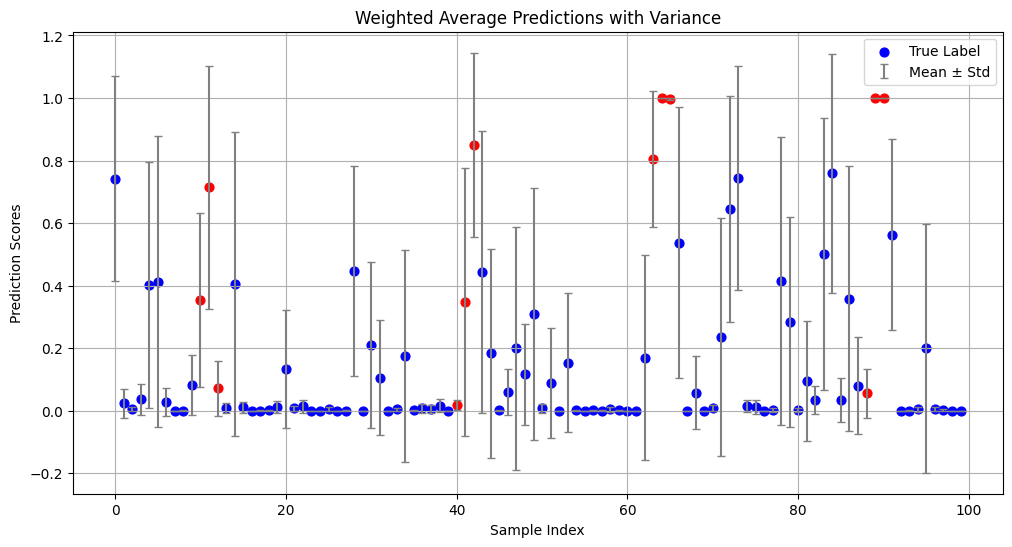

In [159]:
# Combine predictions into a matrix
predictions = np.vstack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores])

# Compute mean and standard deviation for each sample
means = predictions.mean(axis=0)
stds = predictions.std(axis=0)

# Plot the results
plt.figure(figsize=(12, 6))

# Mark true labels with solid colors
for i, label in enumerate(true_labels[:100]):
    plt.scatter(
        i, means[i],
        c='red' if label == 1 else 'blue',  # Solid red or blue color
        s=40,
        label='True Label' if i == 0 else ""
    )

plt.errorbar(
    range(len(means))[:100], 
    means[:100], 
    yerr=stds[:100], 
    fmt=' ',  # No marker for error bars
    ecolor='gray',  # Color of error bars
    capsize=3, 
    label='Mean ± Std'
)

# Plot settings
plt.xlabel('Sample Index')
plt.ylabel('Prediction Scores')
plt.title('Weighted Average Predictions with Variance')
plt.legend()
plt.grid()
plt.show()


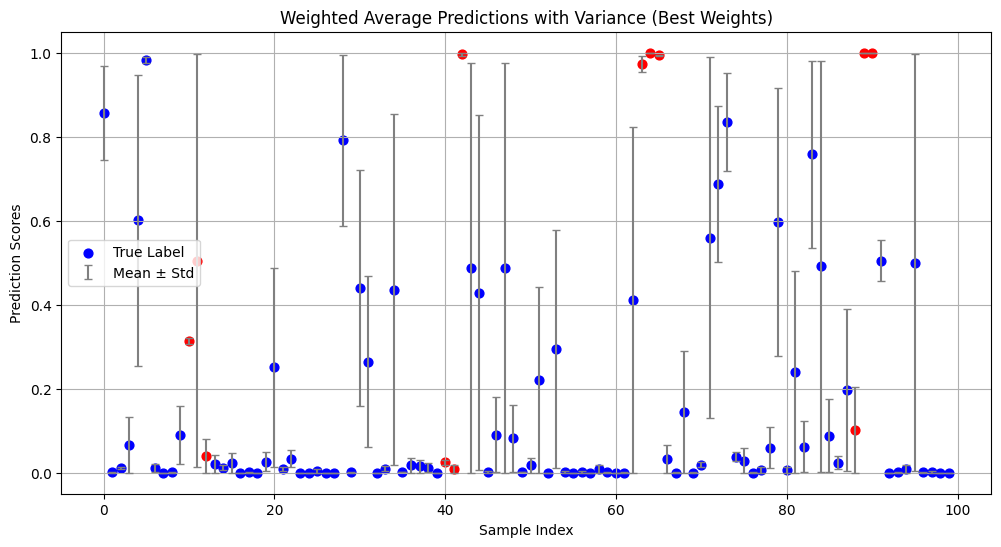

In [160]:
# Define the best weights
weights = np.array([0.5, 0, 0, 0.5, 0])

# Combine predictions into a matrix
predictions = np.vstack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores])

# Compute weighted mean and standard deviation for each sample
weighted_means = np.average(predictions, axis=0, weights=weights)
weighted_stds = np.sqrt(
    np.average((predictions - weighted_means) ** 2, axis=0, weights=weights)
)

# Plot the results
plt.figure(figsize=(12, 6))

# Mark true labels with solid colors
for i, label in enumerate(true_labels[:100]):
    plt.scatter(
        i, weighted_means[i],
        c='red' if label == 1 else 'blue',  # Solid red or blue color
        s=40,
        label='True Label' if i == 0 else ""
    )

# Plot mean +- std with error bars after scatter
plt.errorbar(
    range(len(weighted_means))[:100], 
    weighted_means[:100], 
    yerr=weighted_stds[:100], 
    fmt=' ',  # No marker for error bars
    ecolor='gray',  # Color of error bars
    capsize=3, 
    label='Mean ± Std'
)

# Plot settings
plt.xlabel('Sample Index')
plt.ylabel('Prediction Scores')
plt.title('Weighted Average Predictions with Variance (Best Weights)')
plt.legend()
plt.grid()
plt.show()


In [161]:
means = predictions.mean(axis=0)
stds = predictions.std(axis=0)

print(f'{predictions.shape=}; {means.shape=}')
print(f'{stds.shape=}')

predictions.shape=(5, 6320); means.shape=(6320,)
stds.shape=(6320,)


In [162]:
print(f"{predictions[:,0]=}; {means[0]=}; {stds[0]=}")
print(means[0])
print(stds[0])

predictions[:,0]=array([0.7447331 , 0.88549119, 1.        , 0.96756357, 0.11008   ]); means[0]=0.7415735721588135; stds[0]=0.32782986089328664
0.7415735721588135
0.32782986089328664


In [163]:
# compute the mean variance for samples with label 1, if the mean score is lower than 0.9
mean_var_label_FN = np.mean(stds[(true_labels == 1) & (means < 0.9)])
print(f"Mean Variance for false negative: {mean_var_label_FN:.4f}")

mean_var_label_FP = np.mean(stds[(true_labels == 0) & (means > 0.9)])
print(f"Mean variance for false positive {mean_var_label_FP:.4f}")

mean_var_label_TN = np.mean(stds[(true_labels == 0) & (means < 0.9)])
print(f"Mean variance for true negative {mean_var_label_TN:.4f}")

mean_var_label_TP = np.mean(stds[(true_labels == 1) & (means > 0.9)])
print(f"Mean variance for true positive {mean_var_label_TP:.4f}")



Mean Variance for false negative: 0.2399
Mean variance for false positive 0.0363
Mean variance for true negative 0.1677
Mean variance for true positive 0.0194


In [165]:
def confidence_based_thresholding(predictions, variance, high_variance_threshold=0.1):
    final_predictions = []
    for i in range(len(predictions)):
        if variance[i] > high_variance_threshold:
            # If the variance is high, we will classify it as 'uncertain' or not predict
            final_predictions.append(-1)  # -1 indicates uncertain prediction
        else:
            final_predictions.append(predictions[i])
    return np.array(final_predictions)


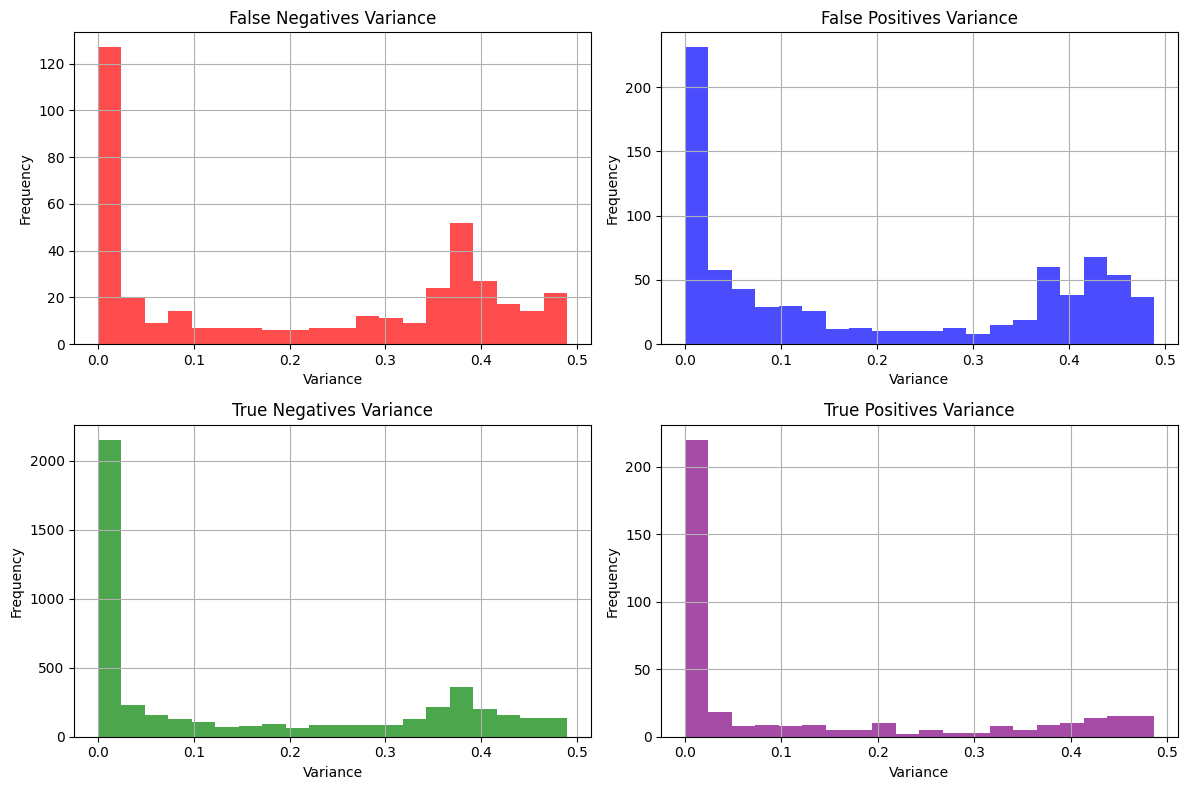

In [166]:
# Classify the predictions into FP, TN, FN, TP using confusion matrix
predicted_labels = weighted_means > 0.8
true_labels = np.loadtxt('/home/mihai/Thesis/Data/TSC_scores/true_labels_50_overlap.csv', delimiter=',') 
cm = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = cm.ravel()  # Flatten the confusion matrix to get counts for each class

# Filter variance values based on confusion matrix
fn_variances = stds[(true_labels == 1) & (predicted_labels == 0)]  # False Negatives
fp_variances = stds[(true_labels == 0) & (predicted_labels == 1)]  # False Positives
tn_variances = stds[(true_labels == 0) & (predicted_labels == 0)]  # True Negatives
tp_variances = stds[(true_labels == 1) & (predicted_labels == 1)]  # True Positives


# Plot histograms for FP, TN, FN, TP variances
plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
plt.grid()
plt.hist(fn_variances, bins=20, color='red', alpha=0.7)
plt.title('False Negatives Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.grid()
plt.hist(fp_variances, bins=20, color='blue', alpha=0.7)
plt.title('False Positives Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.grid()
plt.hist(tn_variances, bins=20, color='green', alpha=0.7)
plt.title('True Negatives Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.grid()
plt.hist(tp_variances, bins=20, color='purple', alpha=0.7)
plt.title('True Positives Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [225]:
def dynamic_threshold(predictions, variances, base_threshold=0.9, variance_factor=0.1):
    """
    Dynamically adjust the threshold based on variance and return the predictions.
    
    :param predictions: The weighted mean predictions.
    :param variances: The variance (or standard deviation) of the predictions.
    :param base_threshold: The base threshold when variance is zero.
    :param variance_factor: The factor by which the threshold is adjusted based on variance.
    
    :return: The predicted labels (0 or 1) based on the dynamic thresholding.
    """
    # Compute the dynamic threshold for each prediction based on the corresponding variance
    adjusted_thresholds = base_threshold + variance_factor * np.sqrt(variances)
    adjusted_thresholds = np.clip(adjusted_thresholds, 0.5, 1.0)  # Ensure threshold is between 0 and 1
    
    # Apply the dynamic thresholds to the predictions
    predictions_class = predictions > adjusted_thresholds  # Classify as 1 (positive) if prediction > threshold, else 0 (negative)
    
    return predictions_class

def optimize_dynamic_threshold(predictions, variances, true_labels, base_thresholds, variance_factors):
    """
    Try different combinations of base threshold and variance factor to get the best F1 score.
    
    :param predictions: The weighted mean predictions.
    :param variances: The variance (or standard deviation) of the predictions.
    :param true_labels: The actual true labels (0 or 1).
    :param base_thresholds: List of base thresholds to try.
    :param variance_factors: List of variance factors to try.
    
    :return: The best base_threshold, variance_factor, and the corresponding F1 score.
    """
    best_f1 = -1  # Start with a very low F1 score
    best_base_threshold = None
    best_variance_factor = None
    
    # Iterate over different base thresholds and variance factors
    for base_threshold in base_thresholds:
        for variance_factor in variance_factors:
            # Get predictions using dynamic threshold
            predictions_dynamic = dynamic_threshold(predictions, variances, base_threshold, variance_factor)
            
            # Calculate the F1 score
            f1 = f1_score(true_labels, predictions_dynamic)
            
            # Update the best parameters if the current F1 score is higher
            if f1 > best_f1:
                best_f1 = f1
                best_base_threshold = base_threshold
                best_variance_factor = variance_factor
                
    return best_base_threshold, best_variance_factor, best_f1

# Example usage:

# Range of base thresholds and variance factors to try
base_thresholds = np.arange(0.5, 1.0, 0.025)  # From 0.5 to 1.0 with step of 0.05
variance_factors = np.arange(0.0, 0.5, 0.02)  # From 0.0 to 0.5 with step of 0.05

weights = np.array([0.3333, 0, 0, 0.6667, 0])

# Combine predictions into a matrix
predictions = np.vstack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores])

# Compute weighted mean and standard deviation for each sample
weighted_means = np.average(predictions, axis=0, weights=weights)
weighted_stds = np.sqrt(
    np.average((predictions - weighted_means) ** 2, axis=0, weights=weights)
)

# Assuming weighted_means, weighted_stds, and true_labels are already defined
best_base_threshold, best_variance_factor, best_f1 = optimize_dynamic_threshold(
    weighted_means, weighted_stds, true_labels, base_thresholds, variance_factors
)

print(f"Best Base Threshold: {best_base_threshold}")
print(f"Best Variance Factor: {best_variance_factor}")
print(f"Best F1 Score: {best_f1}")

Best Base Threshold: 0.9000000000000004
Best Variance Factor: 0.0
Best F1 Score: 0.40526617057813397


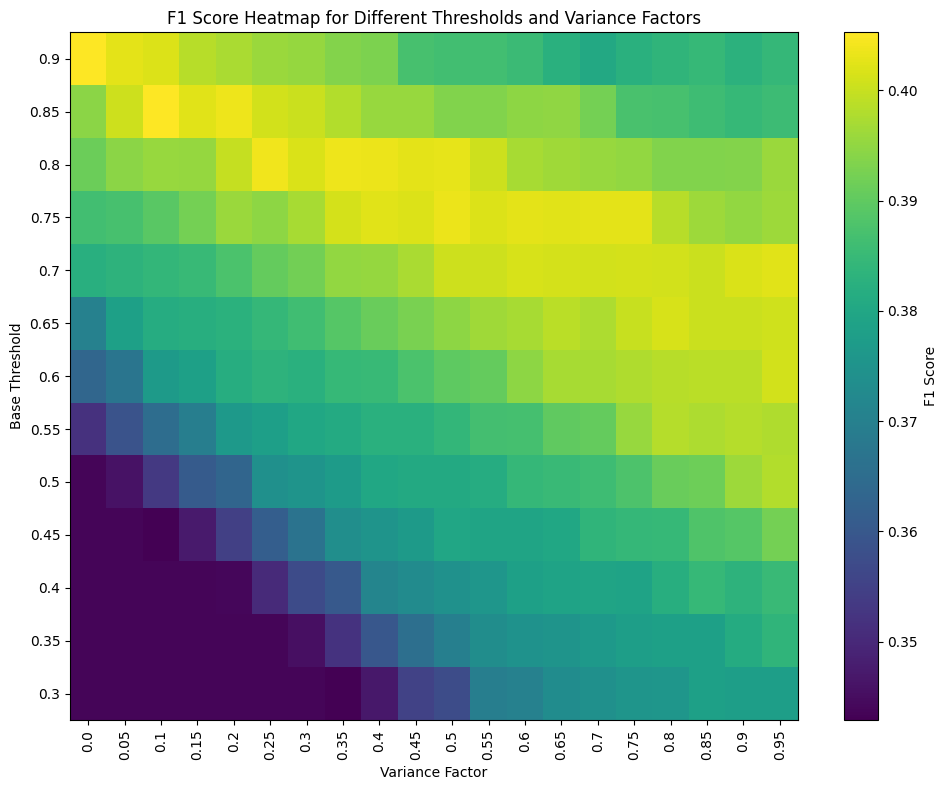

In [226]:
def optimize_dynamic_threshold(predictions, variances, true_labels, base_thresholds, variance_factors):
    f1_matrix = np.zeros((len(base_thresholds), len(variance_factors)))
    
    # Iterate over different base thresholds and variance factors
    for i, base_threshold in enumerate(base_thresholds):
        for j, variance_factor in enumerate(variance_factors):
            # Get predictions using dynamic threshold
            predictions_dynamic = dynamic_threshold(predictions, variances, base_threshold, variance_factor)
            
            # Calculate the F1 score
            f1 = f1_score(true_labels, predictions_dynamic)
            
            # Store the F1 score in the matrix
            f1_matrix[i, j] = f1

    # Return the F1 score matrix
    return f1_matrix

# Example usage
base_thresholds = np.arange(0.3, 0.95, 0.05)  # From 0.5 to 1.0 with step of 0.05
variance_factors = np.arange(0.0, 1, 0.05)  # From 0.0 to 0.5 with step of 0.01

# Assuming weighted_means, weighted_stds, and true_labels are already defined
f1_matrix = optimize_dynamic_threshold(weighted_means, weighted_stds, true_labels, base_thresholds, variance_factors)

# Plotting the heatmap of F1 scores
plt.figure(figsize=(10, 8))
plt.imshow(f1_matrix, cmap='viridis', aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar(label='F1 Score')

# Add labels and ticks
plt.xticks(np.arange(len(variance_factors)), variance_factors.round(2), rotation=90)
plt.yticks(np.arange(len(base_thresholds)), base_thresholds.round(2))
plt.xlabel('Variance Factor')
plt.ylabel('Base Threshold')
plt.title('F1 Score Heatmap for Different Thresholds and Variance Factors')

# Show the plot
plt.tight_layout()
plt.show()

In [227]:
predictions_dynamic = dynamic_threshold(weighted_means, weighted_stds, base_threshold=0.75, variance_factor=0.25)
print(f1_score(true_labels, predictions_dynamic))

0.3946808510638298


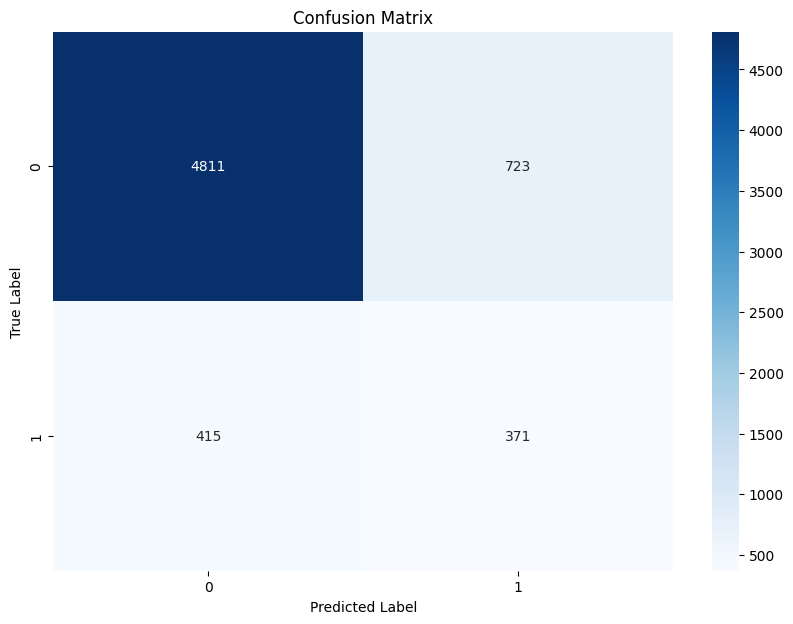

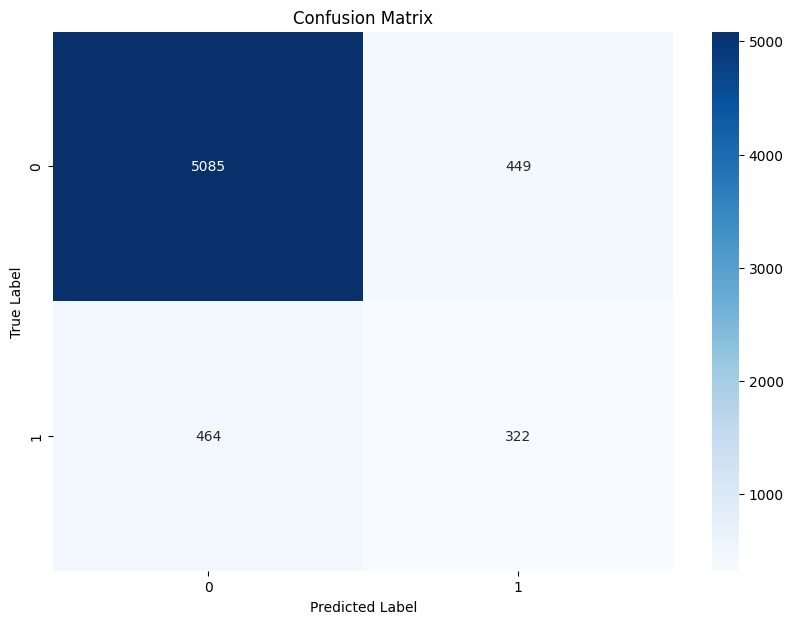

0.41361592806679515


In [228]:
plot_heatmap(true_labels, predictions_dynamic)
filtered_predictions = filter_isolated_predictions(predictions_dynamic)
plot_heatmap(true_labels, filtered_predictions)
print(f1_score(true_labels, filtered_predictions))

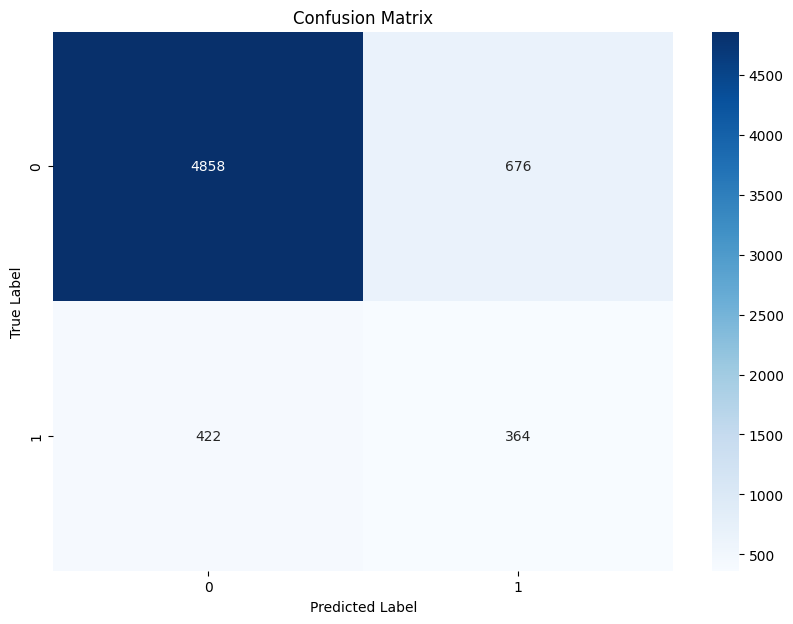

0.39868565169769987


In [175]:
plot_heatmap(true_labels, weighted_predicted_labels)
print(f1_score(true_labels, weighted_predicted_labels))

## Analyse only the extreme events

In [176]:
def apply_windowing_to_tc(data, window_length=150, overlap=0.5):
    """
    Applies windowing to each column of the input array.

    Args:
        data (numpy.ndarray): 2D array where each column is to be windowed.
        window_length (int): The length of each window.
        overlap (float): The percentage of overlap (0 < overlap < 1).

    Returns:
        numpy.ndarray: 2D array where each column has been windowed.
    """
    # Initialize a list to hold windowed columns
    windowed_columns = []

    # Apply windowing to each column
    for col in range(data.shape[1]):
        # Extract the column
        column_data = data[:, col]

        # Apply create_windows to the column
        windowed_column = create_windows(column_data, window_length, overlap)

        # Add the windowed column to the list
        windowed_columns.append(windowed_column)

    return np.array(windowed_columns)


def create_windows(signal_column, window_length, overlap):
    """
    Creates overlapping windows for a given signal column.

    Args:
        signal_column (numpy.ndarray): A 1D array of the signal.
        window_length (int): The length of each window.
        overlap (float): The percentage of overlap (0 < overlap < 1).

    Returns:
        numpy.ndarray: A 2D array where each row is a windowed segment of the signal.
    """
    step = int(window_length * (1 - overlap))  # Compute the step size based on the overlap
    windows = [signal_column[i:i + window_length] for i in range(0, len(signal_column) - window_length + 1, step)]
    return np.array(windows)

md_distances = np.loadtxt(r"/home/mihai/Thesis/MD_distances_per_run.csv", delimiter=',').transpose()
md_windows = apply_windowing_to_tc(md_distances, window_length=150, overlap=0.5)

In [177]:
from scipy.stats import chi2

def detect_extreme_events(md_windows, alpha=3):
    # Get the number of runs, windows, and samples per window
    nb_runs, nb_windows, _ = md_windows.shape
    
    # Initialize the array to store the extreme event labels
    extreme_events = np.zeros((nb_runs, nb_windows, 1), dtype=int)

    # Iterate over each run and window
    for run in range(nb_runs):
        for window in range(nb_windows):
            # Get the Mahalanobis distance for the current window
            md_value = md_windows[run, window]
            md_value = np.max(md_value)

            # If the p-value is less than alpha, mark the window as extreme (1)
            if md_value > alpha:
                extreme_events[run, window] = 1
    
    return extreme_events

extreme_events = detect_extreme_events(md_windows)[:,1:]

ev_2d = extreme_events.flatten()
true_labels.shape, ev_2d.shape

indices = np.where(ev_2d == 1)[0]

# Sum the corresponding true_labels values at those indices
sum_true_labels = np.sum(true_labels[indices])
print(f"Sum of True Labels: {sum_true_labels}; out of {len(indices)} extreme events")

Sum of True Labels: 372.0; out of 798 extreme events


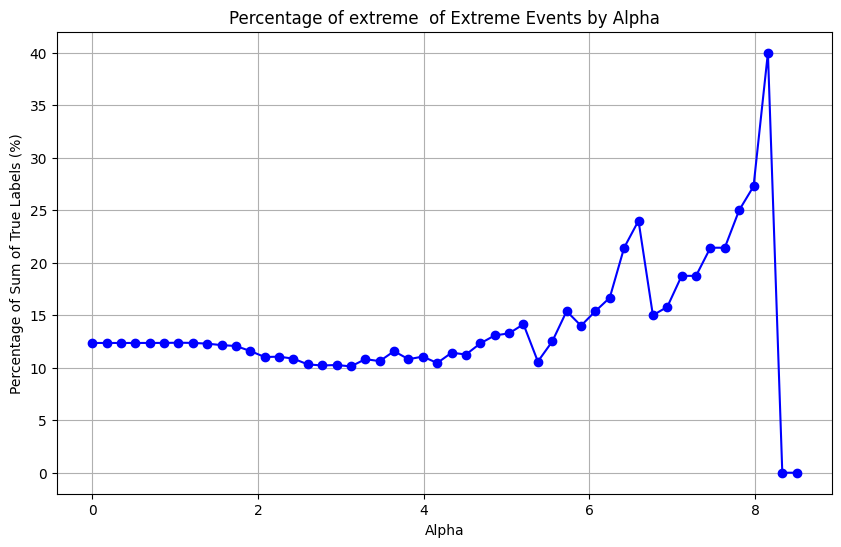

In [178]:
def plot_percentage(md_windows, true_labels, alpha_values):
    percentages = []
    
    for alpha in alpha_values:
        # Get extreme events for the given alpha
        extreme_events = detect_extreme_events(md_windows, alpha)
        
        # Flatten extreme events to 1D array
        ev_2d = extreme_events.flatten()
        
        # Get the indices where ev_2d == 1
        indices = np.where(ev_2d == 1)[0]
        
        if len(indices) == 0:
            # Avoid division by zero if there are no extreme events
            percentages.append(0)
            continue
        
        # Ensure indices are within bounds of true_labels
        indices = np.clip(indices, 0, len(true_labels) - 1)
        
        # Sum the corresponding true_labels values at those indices
        sum_true_labels = np.sum(true_labels[indices])
        
        # Calculate the percentage of sum of true_labels out of the extreme events
        percentage = (sum_true_labels / len(indices)) * 100
        percentages.append(percentage)
    
    # Plot the result
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, percentages, marker='o', linestyle='-', color='b')
    plt.title("Percentage of extreme  of Extreme Events by Alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Percentage of Sum of True Labels (%)")
    plt.grid(True)
    plt.show()

# Example usage:
alpha_values = np.linspace(0, 8.5, 50)  # Vary alpha from 0 to 10, 50 points
plot_percentage(md_windows, true_labels, alpha_values)

In [179]:
ev_2d = extreme_events.flatten()
true_labels.shape, ev_2d.shape

indices = np.where(ev_2d == 1)[0]

# Sum the corresponding true_labels values at those indices
sum_true_labels = np.sum(true_labels[indices])
print(f"Sum of True Labels: {sum_true_labels}; out of {len(indices)} extreme events")

Sum of True Labels: 372.0; out of 798 extreme events


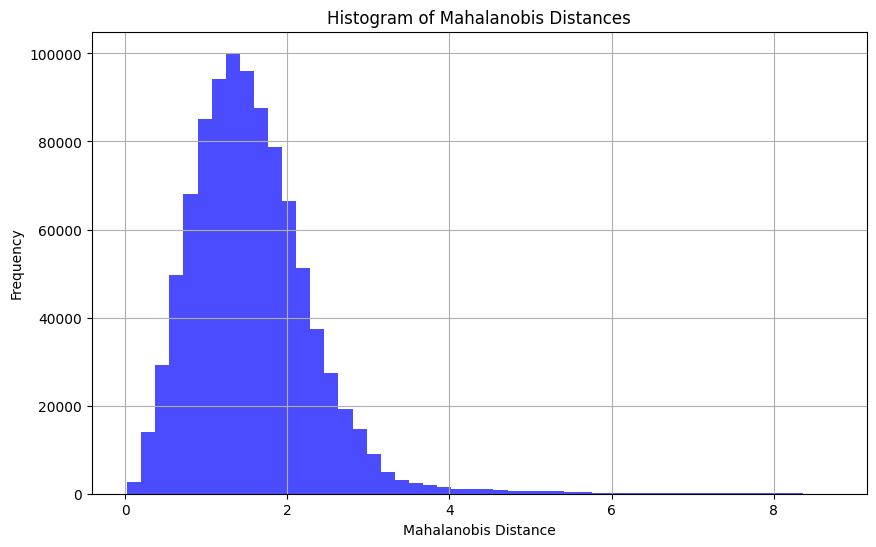

In [ ]:
def plot_md_histogram(md_windows):
    # Flatten the md_windows array to create a single list of all Mahalanobis distances
    md_values = md_windows.flatten()
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(md_values, bins=50, color='blue', alpha=0.7)
    plt.title("Histogram of Mahalanobis Distances")
    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_md_histogram(md_windows)

/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


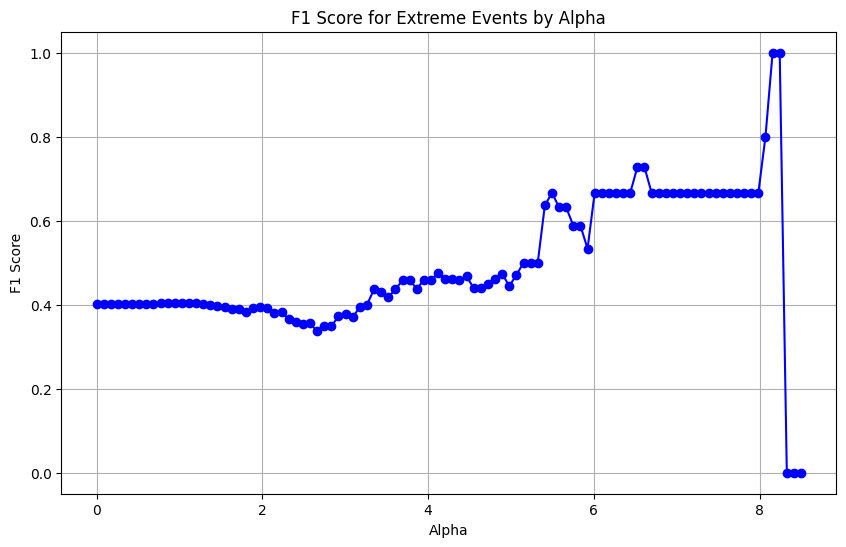

Best alpha: 8.156565656565656
Best F1 Score: 1.0


In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.metrics import f1_score

def detect_extreme_events(md_windows, alpha=3):
    # Get the number of runs, windows, and samples per window
    nb_runs, nb_windows, _ = md_windows.shape
    
    # Initialize the array to store the extreme event labels
    extreme_events = np.zeros((nb_runs, nb_windows, 1), dtype=int)

    # Iterate over each run and window
    for run in range(nb_runs):
        for window in range(nb_windows):
            # Get the Mahalanobis distance for the current window
            md_value = md_windows[run, window]
            md_value = np.max(md_value)

            # If the p-value is less than alpha, mark the window as extreme (1)
            if md_value > alpha:
                extreme_events[run, window] = 1
    
    return extreme_events

def dynamic_threshold(predictions, variances, base_threshold=0.9, variance_factor=0.1):
    """
    Dynamically adjust the threshold based on variance and return the predictions.
    """
    # Compute the dynamic threshold for each prediction based on the corresponding variance
    adjusted_thresholds = base_threshold + variance_factor * np.sqrt(variances)
    adjusted_thresholds = np.clip(adjusted_thresholds, 0.5, 1.0)  # Ensure threshold is between 0 and 1
    
    # Apply the dynamic thresholds to the predictions
    predictions_class = predictions > adjusted_thresholds  # Classify as 1 (positive) if prediction > threshold, else 0 (negative)
    
    return predictions_class

def compute_f1_for_alpha(md_windows, true_labels, alpha_values, weighted_means, weighted_stds):
    f1_scores = []
    
    nb_runs, nb_windows, nb_samples = md_windows.shape
    true_labels_flattened = true_labels.flatten()

    for alpha in alpha_values:
        # Detect extreme events for the given alpha
        extreme_events = detect_extreme_events(md_windows, alpha)
        
        # Flatten extreme events
        ev_2d = extreme_events.flatten()

        # Only focus on the extreme event indices (ev_2d == 1)
        extreme_event_indices = np.where(ev_2d == 1)[0]

        if len(extreme_event_indices) == 0:
            f1_scores.append(0)
            continue
        
        # Ensure the indices are within bounds of the weighted_means and weighted_stds
        if np.max(extreme_event_indices) >= len(weighted_means):
            print(f"Warning: Some extreme events fall outside of the bounds of the weighted_means array.")
            extreme_event_indices = extreme_event_indices[extreme_event_indices < len(weighted_means)]
        
        # Get the predictions and variances for the extreme events
        predictions = weighted_means[extreme_event_indices]
        variances = weighted_stds[extreme_event_indices]
        
        # Apply dynamic thresholding to get predicted labels
        predicted_labels = dynamic_threshold(predictions, variances)
        
        # Calculate the F1 score for the extreme events
        f1 = f1_score(true_labels_flattened[extreme_event_indices], predicted_labels)
        f1_scores.append(f1)
    
    return f1_scores

# Example usage:
alpha_values = np.linspace(0, 8.5,100)  # Vary alpha from 0 to 10, 50 points

weights = np.array([0.3335, 0, 0, 0.6665, 0])

# Combine predictions into a matrix
predictions = np.vstack([lstm_scores, rnn_scores, inception_scores, fcn_scores, resnet_scores])

# Compute weighted mean and standard deviation for each sample
weighted_means = np.average(predictions, axis=0, weights=weights)

# Assuming weighted_means, weighted_stds, and true_labels are already defined
f1_scores = compute_f1_for_alpha(md_windows, true_labels, alpha_values, weighted_means, weighted_stds)

# Plot the F1 scores as a function of alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, f1_scores, marker='o', linestyle='-', color='b')
plt.title("F1 Score for Extreme Events by Alpha")
plt.xlabel("Alpha")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# Optionally, print the best F1 score and corresponding alpha
best_alpha = alpha_values[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"Best alpha: {best_alpha}")
print(f"Best F1 Score: {best_f1}")


Best alpha: 8.181818181818182
Best F1 Score: 1.0


/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/miha

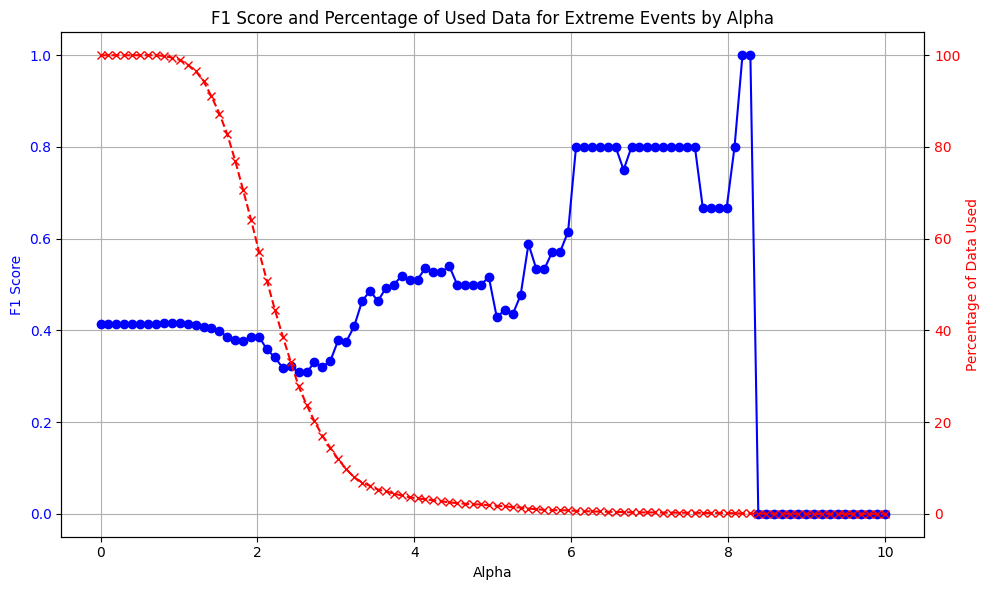

Best alpha: 8.181818181818182
Best F1 Score: 1.0


In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.metrics import f1_score

def detect_extreme_events(md_windows, alpha=3):
    """
    Detect extreme events based on Mahalanobis distance and a given alpha threshold.
    """
    nb_runs, nb_windows, _ = md_windows.shape
    extreme_events = np.zeros((nb_runs, nb_windows, 1), dtype=int)

    for run in range(nb_runs):
        for window in range(nb_windows):
            md_value = md_windows[run, window]
            md_value = np.max(md_value)

            if md_value > alpha:
                extreme_events[run, window] = 1
    
    return extreme_events

def dynamic_threshold(predictions, variances, base_threshold=0.9, variance_factor=0.1):
    """
    Dynamically adjust the threshold based on variance and return the predictions.
    """
    adjusted_thresholds = base_threshold + variance_factor * np.sqrt(variances)
    adjusted_thresholds = np.clip(adjusted_thresholds, 0.5, 1.0)  # Ensure threshold is between 0 and 1
    predictions_class = predictions > adjusted_thresholds
    return predictions_class

def compute_f1_and_percentage_for_alpha(md_windows, true_labels, alpha_values, weighted_means, weighted_stds):
    f1_scores = []
    percentage_used = []
    
    nb_runs, nb_windows, nb_samples = md_windows.shape
    true_labels_flattened = true_labels.flatten()

    for alpha in alpha_values:
        # Detect extreme events for the given alpha
        extreme_events = detect_extreme_events(md_windows, alpha)
        
        # Flatten extreme events
        ev_2d = extreme_events.flatten()

        # Calculate the percentage of extreme events (out of total windows/samples)
        percentage = np.sum(ev_2d) / len(ev_2d) * 100
        percentage_used.append(percentage)

        # Only focus on the extreme event indices (ev_2d == 1)
        extreme_event_indices = np.where(ev_2d == 1)[0]

        if len(extreme_event_indices) == 0:
            f1_scores.append(0)
            continue
        
        # Ensure the indices are within bounds of the weighted_means and weighted_stds
        if np.max(extreme_event_indices) >= len(weighted_means):
            print(f"Warning: Some extreme events fall outside of the bounds of the weighted_means array.")
            extreme_event_indices = extreme_event_indices[extreme_event_indices < len(weighted_means)]
        
        # Get the predictions and variances for the extreme events
        predictions = weighted_means[extreme_event_indices]
        variances = weighted_stds[extreme_event_indices]
        
        # Apply dynamic thresholding to get predicted labels
        predicted_labels = dynamic_threshold(predictions, variances)
        filtered_predictions = filter_isolated_predictions(predicted_labels)
        # Calculate the F1 score for the extreme events
        f1 = f1_score(true_labels_flattened[extreme_event_indices], filtered_predictions)
        f1_scores.append(f1)
    
    return f1_scores, percentage_used


# Optionally, print the best F1 score and corresponding alpha
best_alpha = alpha_values[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"Best alpha: {best_alpha}")
print(f"Best F1 Score: {best_f1}")

alpha_values = np.linspace(0, 10, 100)  # Vary alpha from 0 to 10, 50 points
f1_scores, percentage_used = compute_f1_and_percentage_for_alpha(md_windows, true_labels, alpha_values, weighted_means, weighted_stds)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the F1 scores on the first y-axis
ax1.plot(alpha_values, f1_scores, marker='o', linestyle='-', color='b', label='F1 Score')
ax1.set_xlabel("Alpha")
ax1.set_ylabel("F1 Score", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("F1 Score and Percentage of Used Data for Extreme Events by Alpha")
ax1.grid(True)

# Create a second y-axis for the percentage of extreme events
ax2 = ax1.twinx()
ax2.plot(alpha_values, percentage_used, marker='x', linestyle='--', color='r', label='Percentage of Data Used')
ax2.set_ylabel("Percentage of Data Used", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Show the plot
fig.tight_layout()
plt.show()

# Optionally, print the best F1 score and corresponding alpha
best_alpha = alpha_values[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"Best alpha: {best_alpha}")
print(f"Best F1 Score: {best_f1}")
